In [186]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import datasets as datasets
#from sklearn.tree import RandomForestRegressor ## doesn't work
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

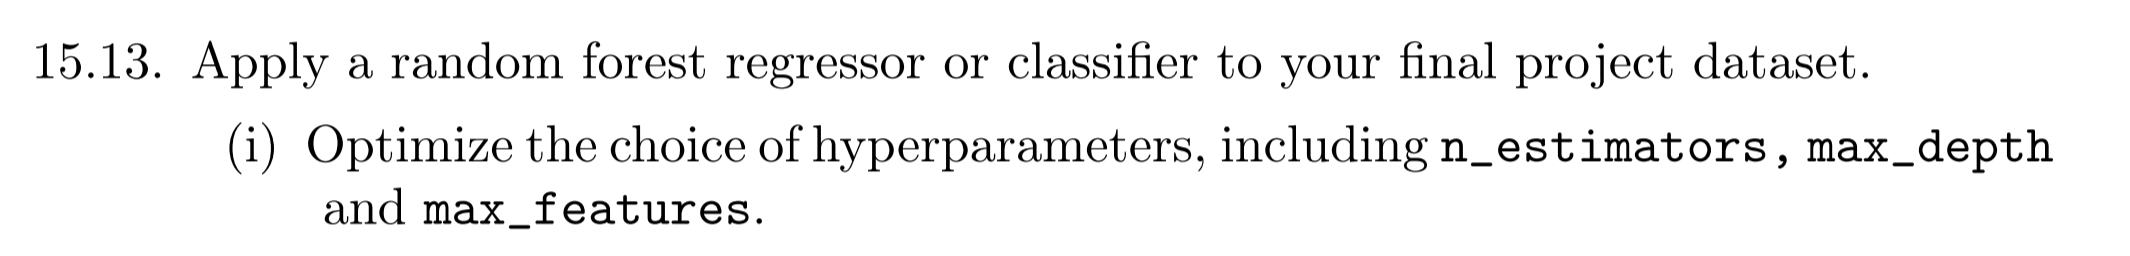

In [216]:
# turns I could consider
np.arange(156,730,5)

array([156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216,
       221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281,
       286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346,
       351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411,
       416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476,
       481, 486, 491, 496, 501, 506, 511, 516, 521, 526, 531, 536, 541,
       546, 551, 556, 561, 566, 571, 576, 581, 586, 591, 596, 601, 606,
       611, 616, 621, 626, 631, 636, 641, 646, 651, 656, 661, 666, 671,
       676, 681, 686, 691, 696, 701, 706, 711, 716, 721, 726])

In [ ]:
## DESIGN THE LIST OF FEATURES
num_players = 6
desired_features = ['Total Reinforcements', 'Troop Count', 'Country Count', 'player_cut_edges'
,'player_number_boundary_nodes','player_connected_components'
,'player_average_boundary_fortifications']
feat = []
for i in range(num_players):
    for j in desired_features:
        feat.append('Player ' + str(i) + ' ' +j)

In [256]:
df = pd.read_hdf('../../402_project/data/01_big_nth_turn_datasets/big2/' + 'big_316_turn.hdf')
df.drop(index=df[df.winner.isna()].index,inplace=True)

In [257]:
# how many games are last longer than a certain number of turns
df = df.loc[(df.total_numer_turns_in_game > 400)].copy()
print(df.shape[0])

3846


In [258]:
# this is what the data looks like
df.sample(3)

,Fifth,Fourth,Player 0 Afghanistan,Player 0 Africa,Player 0 Alaska,Player 0 Alberta,Player 0 Argentina,Player 0 Asia,Player 0 Australia,Player 0 Brazil,...,Player 5 player_boundary_fortifications,Player 5 player_connected_components,Player 5 player_cut_edges,Player 5 player_number_boundary_nodes,Player 5 soft score,Second,Sixth,Third,total_numer_turns_in_game,winner
2731,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,1.0,5.0,2.0,0.20,4.0,1.0,2.0,409.0,3.0
12954,4.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3.0,1.0,4.0,1.0,0.25,2.0,3.0,1.0,628.0,0.0
95,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,3.0,17.0,3.0,1.00,0.0,3.0,4.0,517.0,5.0


# individual cross val

In [259]:
scores = cross_val_score(RandomForestClassifier(max_depth=100,max_features=42,n_estimators=100,oob_score=True,n_jobs=-1,warm_start=False),df[feat],df['winner'],cv=2)
# how to get the oob_score from crossval
print(scores,scores.mean())


[0.33593344 0.3775351 ] 0.3567342693707748


 # Get the best hyper parameters

In [260]:
max_feat_param = np.linspace(1,len(feat),3).astype(int)
print(max_feat_param)
# params = {'max_depth':[30,50,100,150,200],'max_features':max_feat_param}
params = {'max_depth':[30,80,120],'max_features':max_feat_param}
rfc = RandomForestRegressor(n_estimators=100,oob_score=True,n_jobs=-1,warm_start=False)
clf = GridSearchCV(rfc,params,cv=5) #cv=None defaults to 5, 
clf.fit(df[feat],df['winner'])

[ 1 21 42]


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=True, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [30, 80, 120],
         

In [261]:
clf.best_params_

{'max_depth': 120, 'max_features': 21}

In [262]:
clf.best_estimator_.oob_score_

0.22907391179835945

# for all games that last at least x turns, predict just on those, I want to see how predictive capability changes over time in the board game Risk

In [246]:
import os

In [247]:
# have I already produced the file
os.listdir('../../402_project/data/')

['01_big_nth_turn_datasets',
 '.DS_Store',
 'random_forest_01.csv',
 'big2_summary.csv',
 'verify_income_01.csv']

In [273]:
time_sample =60
results = dict()
# list of acceptable turns
summary = pd.read_csv('../../402_project/data/big2_summary.csv')
a = summary['num']
turns_to_consider = a[np.linspace(1,len(a),time_sample).astype(int) - 1]
print(turns_to_consider)

for i,t in enumerate(turns_to_consider):
    try:
        df = pd.read_hdf('../../402_project/data/01_big_nth_turn_datasets/big2/' + f'big_{t}_turn.hdf')

        num_games = df.shape[0]
        stalemates = len(df[df.winner.isna()].index)
        df.drop(index=df[df.winner.isna()].index,inplace=True)
        df = df.loc[(df.total_numer_turns_in_game > 400) & (df.total_numer_turns_in_game < 700)].copy()
        #random forest cross validate 
        scores = cross_val_score(RandomForestClassifier(max_depth=clf.best_params_['max_depth']
                            ,max_features=clf.best_params_['max_features']
                            ,n_estimators=100,oob_score=True,n_jobs=-1,warm_start=False),df[feat],df['winner'],cv=5)

        results[i] = {'turn':t
                      ,'cv_scores':scores
                     ,'mean_oob_score':scores.mean()
                     ,'game_count_without_stalemates':num_games - stalemates
                     ,'stalemate':stalemates
                     ,'num_games':num_games
                     }

        print('done with turn',t)
    except:
        pass
    
keep = pd.DataFrame(results).T
keep.to_csv('../../402_project/data/random_forest_games_lasting_400_to_700_01.csv',index=False)

0      131
2      141
4      151
6      161
8      171
10     181
12     191
14     201
16     211
18     221
20     231
22     241
24     251
26     261
28     271
30     281
32     291
34     301
36     311
38     321
40     331
42     341
44     351
46     361
48     371
50     381
52     391
54     405
56     415
58     425
60     435
62     445
64     455
66     465
68     475
70     485
72     495
74     505
76     515
78     525
80     535
82     545
84     555
86     565
88     575
90     585
92     595
94     605
96     615
98     625
100    635
102    645
104    655
106    665
108    675
110    685
112    695
114    705
116    715
119    730
Name: num, dtype: int64
done with turn 131
done with turn 141
done with turn 151
done with turn 161
done with turn 171
done with turn 181
done with turn 191
done with turn 201
done with turn 211
done with turn 221
done with turn 231
done with turn 241
done with turn 251
done with turn 261
done with turn 271
done with turn 281
done with tu

/Users/joeywilkes/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


done with turn 675


/Users/joeywilkes/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


done with turn 685


In [287]:
keep.shape[0]

56

In [275]:
keep.head(5)

,cv_scores,game_count_without_stalemates,mean_oob_score,num_games,stalemate,turn
0,"[0.1866840731070496, 0.16601307189542483, 0.17...",30272,0.177821,32337,2065,131
1,"[0.18798955613577023, 0.1607843137254902, 0.18...",30272,0.17991,32337,2065,141
2,"[0.18929503916449086, 0.1843137254901961, 0.23...",30272,0.206841,32337,2065,151
3,"[0.20234986945169714, 0.18169934640522875, 0.2...",30272,0.226739,32337,2065,161
4,"[0.21671018276762402, 0.23660130718954248, 0.2...",30272,0.244244,32337,2065,171


In [276]:
keep.tail(5)

,cv_scores,game_count_without_stalemates,mean_oob_score,num_games,stalemate,turn
51,"[1.0, 1.0, 1.0, 0.95, 1.0]",239,0.99,1590,1351,645
52,"[0.95, 1.0, 1.0, 1.0, 1.0]",195,0.99,1428,1233,655
53,"[1.0, 1.0, 1.0, 1.0, 1.0]",150,1,1208,1058,665
54,"[0.9, 0.9, 1.0, 1.0, 1.0]",120,0.96,1050,930,675
55,"[0.5, 0.8, 1.0, 1.0, 1.0]",84,0.86,865,781,685


best params {'max_depth': 120, 'max_features': 21}
turns in consideration [131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 405, 415, 425, 435, 445, 455, 465, 475, 485, 495, 505, 515, 525, 535, 545, 555, 565, 575, 585, 595, 605, 615, 625, 635, 645, 655, 665, 675, 685, 695, 705, 715, 730]


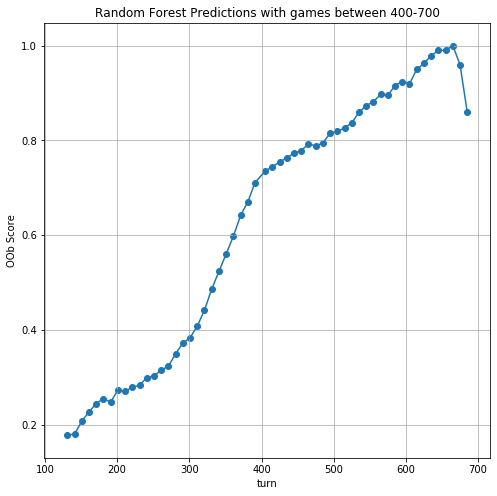

In [277]:
fig = plt.figure(figsize=(8,8))
print('best params',clf.best_params_)
print('turns in consideration',[x for x in turns_to_consider])
plt.plot(keep['turn'],keep['mean_oob_score'])
plt.scatter(keep['turn'],keep['mean_oob_score'])
plt.title('Random Forest Predictions with games between 400-700')
plt.ylabel('OOb Score')
plt.xlabel('turn')
plt.grid()
plt.show()

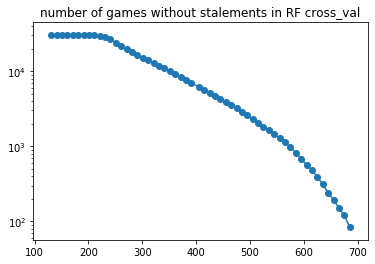

In [285]:

plt.semilogy(keep['turn'],keep['game_count_without_stalemates'])
# plt.plot(keep['turn'],keep['game_count_without_stalemates'])
plt.scatter(keep['turn'],keep['game_count_without_stalemates'])
plt.title('number of games without stalements in RF cross_val')
plt.show()

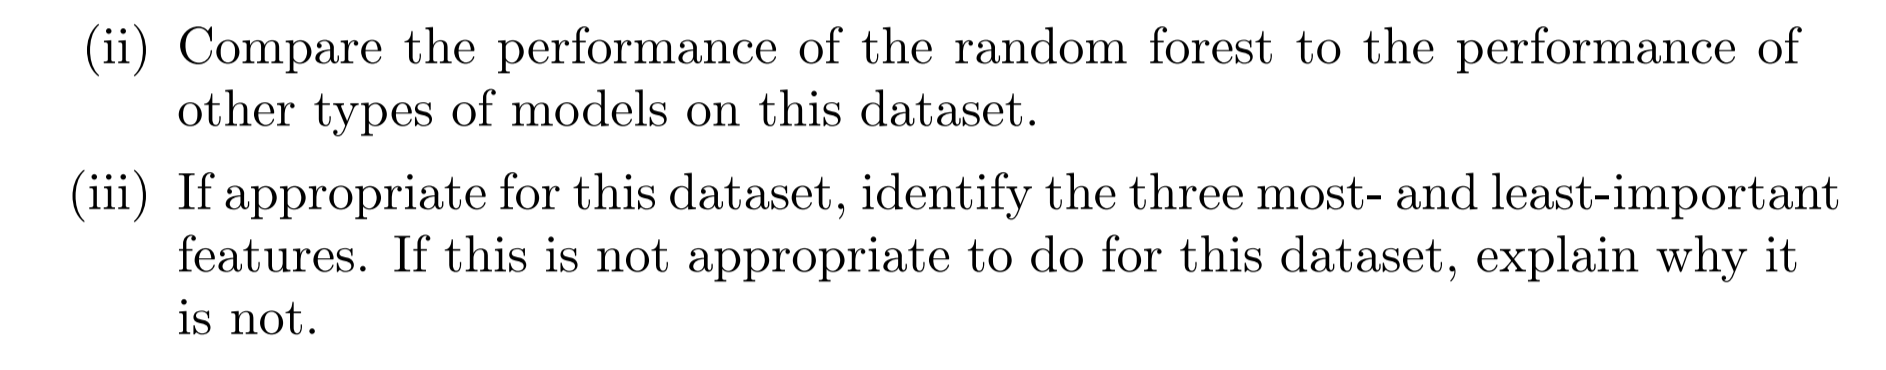

# this is how the logistic regression did over time

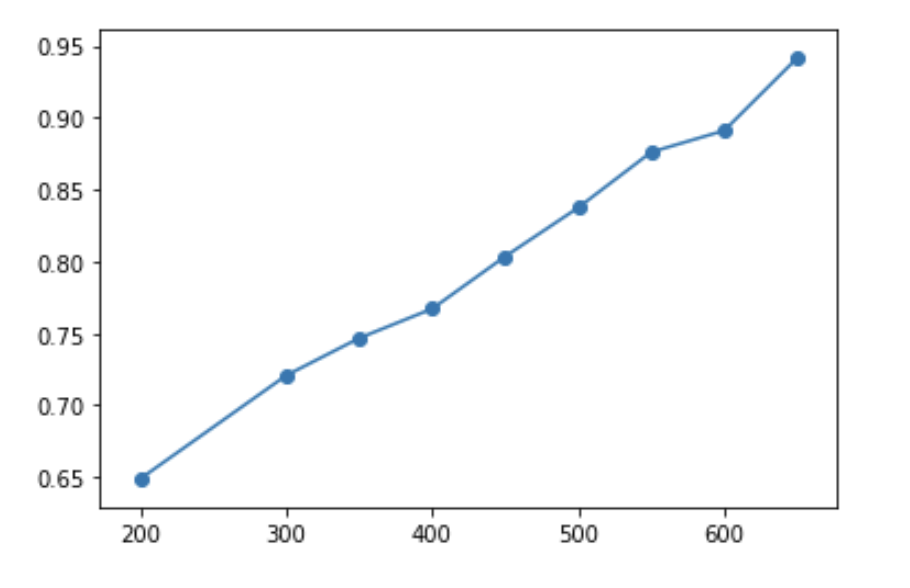

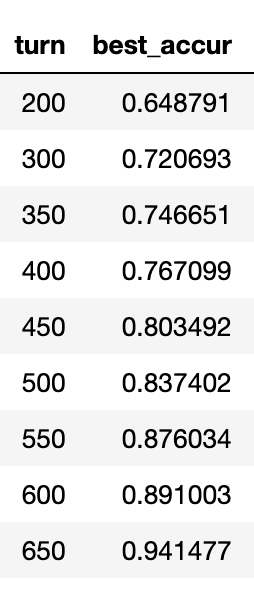

In [272]:
keep[['turn','mean_oob_score','game_count_without_stalemates']]

,turn,mean_oob_score,game_count_without_stalemates
0,131,0.162408,30272
1,171,0.236394,30272
2,216,0.279292,30086
3,256,0.312243,22968
4,301,0.386751,15131
5,341,0.522962,10903
6,386,0.693967,7348
7,430,0.761028,4960
8,475,0.792542,3196
9,515,0.828852,2055


# Analysis comparing logistic regression & Random Forest
<font color='blue'> 
    when comparing closely, the different times of models are pretty similar 
</font>

In [270]:
vals = {feat[i]:np.round(clf.best_estimator_.feature_importances_[i],2) for i in range(len(feat))}
x = pd.Series(vals)
x.sort_values(ascending=False,inplace=True)
x

Player 0 Troop Count                               0.07
Player 0 Country Count                             0.07
Player 2 Troop Count                               0.07
Player 0 Total Reinforcements                      0.04
Player 0 player_average_boundary_fortifications    0.04
Player 1 Country Count                             0.04
Player 4 Troop Count                               0.03
Player 0 player_cut_edges                          0.03
Player 1 Troop Count                               0.03
Player 1 player_average_boundary_fortifications    0.03
Player 2 Country Count                             0.03
Player 3 Troop Count                               0.03
Player 2 player_average_boundary_fortifications    0.03
Player 4 player_average_boundary_fortifications    0.03
Player 5 Troop Count                               0.03
Player 5 Country Count                             0.03
Player 5 Total Reinforcements                      0.02
Player 3 player_average_boundary_fortifications 

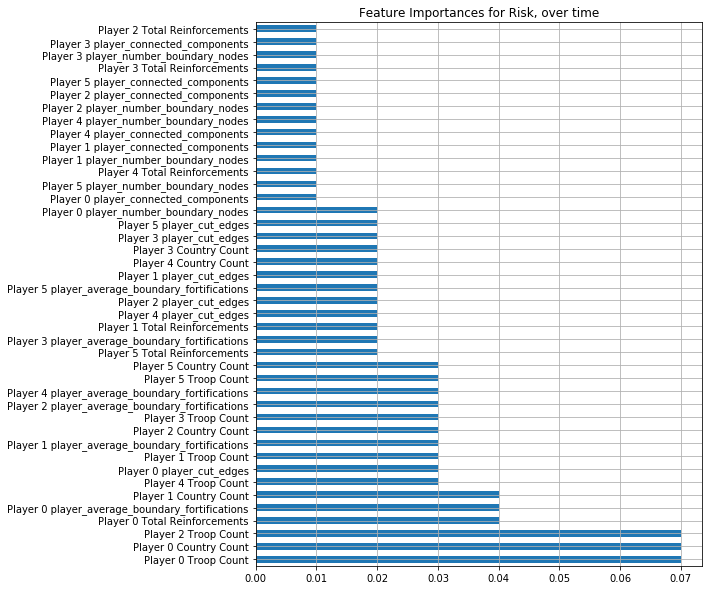

In [271]:
width,height = 8,10
fig = plt.figure(figsize=(width,height))
# plt.barh(feat,clf.best_estimator_.feature_importances_)
x.plot(kind='barh')
plt.grid()
plt.title('Feature Importances for Risk, over time')
plt.show()

# the problem is that we want feature analysis as described for all players, but this is just described for each player..

# There is a bias in the data because player 2 won so many more games - see data visualization on project report